# AWPS - Aguirre's Wager Point System

Below I implement a closed point rating system. I’ll define a “closed point” rating system to be a rating system that distributes a finite number of points to all players in the MLB. These points will be transferred between pitchers and batters each time a pitcher and batter face off.

## Set up env

In [332]:
# import libs
from pybaseball import statcast
from pybaseball.lahman import *
from pybaseball.team_batting import *
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from Helpers import get_statcast_data

# import data
data = get_statcast_data('./data', 2017)
data18 = get_statcast_data('./data', 2018)

## Create helper functions

In [230]:
def event_map(e):
    emap = {
        'single': 'h',
        'double': 'h',
        'triple': 'h',
        'home_run': 'hr',
        'strikeout': 'k'
    }
    if e in emap:
        return emap[e]
    else:
        return -1

def get_proba_function(df):
    """
    Create a function which produces the probability of: a hit (excluding homerun), homerun, and strike
    @param df pandas.DataFrame which has a years seasons worth of statcast data
    @return a function which takes in an event (h, hr, k), and returns a probability of the event
    """
    n_1b = len(df.loc[df.events == 'single'])
    n_2b = len(df.loc[df.events == 'double'])
    n_3b = len(df.loc[df.events == 'triple'])
    n_hr = len(df.loc[df.events == 'home_run'])
    n_so = len(df.loc[df.events == 'strikeout'])
    n_bb = len(df.loc[df.events == 'walk'])
    emap = { 'h': n_1b + n_2b + n_3b, 'hr': n_hr, 'k': n_so }
    return lambda e: emap[e] / sum(list(emap.values()))

def wager(p, b, f=10):
    """
    Calculates the points a pitcher, and a batter should wager on a given event
    @param p float: score of pitcher
    @param b float: score of batter
    @param f int: wager factor, weights how much players should wager
    @return touple (float, float): (pitchers wager, batters wager)
    """
    ep = p/(p + b)
    eb = 1-ep
    return (round(f*ep, 3), round(f*eb, 3))

def get_assign_points_function(pf):
    """
    @param pf float: probability function of an event
    @return function which takes (p, b, e, f) as args
    """
    def assign_points_function(p, b, e, f=10):
        """

        @param p float: score of pitcher
        @param b float: score of batter
        @param e str[] | str: event (h | hr | k)
        @param f int: wager factor, weights how much players should wager
        @return tuple (float, float) which contains (pitchers new points, batters new points)
        """
        pw, bw = wager(p, b, f)
        if type(e) == str:
            event = e
        else:
            event = e.pop(0)
        proba = pf(event)
        points = (None, None)
        if event == 'k':
            points = (p+(bw*(1-proba)), b-(bw*(1-proba)))
        else:
            points = (p-(pw*(1-proba)), b+(pw*(1-proba)))
        points = (round(points[0], 3), round(points[1], 3))
        if type(e) == str or len(e) == 0:
            return points
        else:
            return assign_points_function(points[0], points[1], e, f)
    return assign_points_function

## Define constants

In [301]:
# factor to weight how much points should be wagered in an event
wf = 15
# event probability function
epf = get_proba_function(data)
# assign points function
update_score = get_assign_points_function(epf)

## Examples of how functions work

### Event Probability Function

In [302]:
print('probability of a hit (includes single, double, triple) is', epf('h'))
print('probability of a homerun is', epf('hr'))
print('probability of a strikeout is', epf('k'))

probability of a hit (includes single, double, triple) is 0.4366820362349215
probability of a homerun is 0.07416981044199153
probability of a strikeout is 0.489148153323087


### Wager Function

The following examples will show the properties of the wager function.

1. If two players have the same amount of points, they will wager a constant number of points (which depends on the wager factor) no matter how high or low thier points are compared to other players.
2. The amount of points wagered depends on the difference in skill level. The bigger the gap, the more points will be wagered by each player.

The format of the following example are {player#}:{points}:{wager}, example => {p1:1500:5}

In [303]:
p1, p2 = 1500, 1500
p1w, p2w = wager(p1, p2, wf)
print('SAME number of points => (p1:{}:{}, p2:{}:{})'
      .format(p1, p1w, p2, p2w))

p1, p2 = 1300, 1300
p1w, p2w = wager(p1, p2, wf)
print('SAME number of points => (p1:{}:{}, p2:{}:{})'
      .format(p1, p1w, p2, p2w))

p1, p2 = 1400, 1500
p1w, p2w = wager(p1, p2, wf)
print('DIFFERENT number of points SMALL GAP => (p1:{}:{}, p2:{}:{})'
      .format(p1, p1w, p2, p2w))

p1, p2 = 1000, 1700
p1w, p2w = wager(p1, p2, wf)
print('DIFFERENT number of points LARGE GAP => (p1:{}:{}, p2:{}:{})'
      .format(p1, p1w, p2, p2w))

SAME number of points => (p1:1500:7.5, p2:1500:7.5)
SAME number of points => (p1:1300:7.5, p2:1300:7.5)
DIFFERENT number of points SMALL GAP => (p1:1400:7.241, p2:1500:7.759)
DIFFERENT number of points LARGE GAP => (p1:1000:5.556, p2:1700:9.444)


### Update Score Function (or Assign Points Function)

In [304]:
# pitcher who is pitching
pitcher = 1500
# list of batters up to bat with the result of each event
batter_event = [[1500, 'k'], [1400, 'k'], [1300, 'k'], [1450, 'h'], [1400, 'k'], [1600, 'hr']]
for i in range(len(batter_event)):
    batter, event = batter_event[i]
    pitcher, batter_event[i] = update_score(pitcher, batter, event, wf)

print('pitchers final points from this string of events is', pitcher)
print('updated batter points', batter_event)

pitchers final points from this string of events is 1503.708
updated batter points [1496.169, 1396.306, 1296.452, 1454.312, 1396.309, 1606.744]


## Running the algorithm

+ Initialize by giving every player the same number of points (e.g., 1500 points) at the start of a some season.
+ Before each event (single, double, triple, hr, k), compute how much each player will wager based on their skill levels. The player with the higher skill level will wager more points than a player with less points.
+ After each event, depending on the probability of the event, compute how much of the wagered points will be transferred to the other player.


### 2017 Season Data

In [305]:
point_df = data.loc[:, ('game_date', 'game_pk', 'sv_id', 'pitcher', 'batter', 'events')].copy()
points_df = point_df.sort_values(['game_date', 'sv_id'])
pitchers = { int(p): [1500.0] for p in point_df.pitcher.unique()}
batters = { int(b): [1500.0] for b in point_df.batter.unique()}

In [306]:
for row in point_df.iterrows():
    row = row[1]
    event = event_map(row.events)
    if event != -1:
        p_id = int(row.pitcher)
        b_id = int(row.batter)
        update = update_score(pitchers[p_id][-1], batters[b_id][-1], event, wf)
        pitchers[p_id].append(update[0])
        batters[b_id].append(update[1])

In [268]:
# sort the batters and pitchers by thier final scores
batters_sorted = sorted([(k, v[-1]) for k, v in batters.items()], key=lambda x: x[1])
pitchers_sorted = sorted([(k, v[-1]) for k, v in pitchers.items()], key=lambda x: x[1])

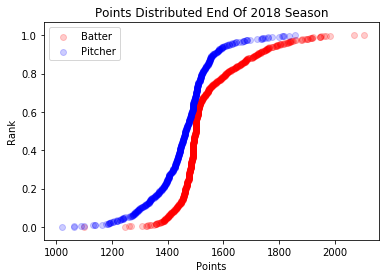

In [331]:
# plot the final points of all players
plt.scatter(np.array(batters_sorted).transpose()[1], np.linspace(0, 1, len(batters_sorted)), color='r', alpha=.2)
plt.scatter(np.array(pitchers_sorted).transpose()[1], np.linspace(0, 1, len(pitchers_sorted)), color='b', alpha=.2)
plt.title('Points Distributed End Of 2017 Season')
plt.ylabel('Rank')
plt.xlabel('Points')
plt.legend(['Batter', 'Pitcher'])
plt.show()

### 2018 Season Data

In [333]:
point_df = data18.loc[:, ('game_date', 'game_pk', 'sv_id', 'pitcher', 'batter', 'events')].copy()
points_df = point_df.sort_values(['game_date', 'sv_id'])
pitchers = { int(p): [1500.0] for p in point_df.pitcher.unique()}
batters = { int(b): [1500.0] for b in point_df.batter.unique()}

In [334]:
for row in point_df.iterrows():
    row = row[1]
    event = event_map(row.events)
    if event != -1:
        p_id = int(row.pitcher)
        b_id = int(row.batter)
        update = update_score(pitchers[p_id][-1], batters[b_id][-1], event, wf)
        pitchers[p_id].append(update[0])
        batters[b_id].append(update[1])

In [335]:
# sort the batters and pitchers by thier final scores
batters_sorted = sorted([(k, v[-1]) for k, v in batters.items()], key=lambda x: x[1])
pitchers_sorted = sorted([(k, v[-1]) for k, v in pitchers.items()], key=lambda x: x[1])

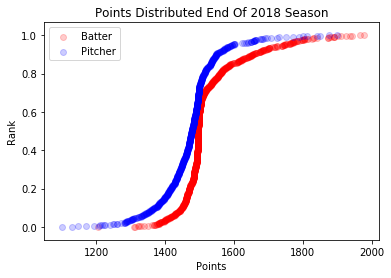

In [337]:
# plot the final points of all players
plt.scatter(np.array(batters_sorted).transpose()[1], np.linspace(0, 1, len(batters_sorted)), color='r', alpha=.2)
plt.scatter(np.array(pitchers_sorted).transpose()[1], np.linspace(0, 1, len(pitchers_sorted)), color='b', alpha=.2)
plt.title('Points Distributed End Of 2018 Season')
plt.ylabel('Rank')
plt.xlabel('Points')
plt.legend(['Batter', 'Pitcher'])
plt.show()

# NOTES

+ Useful for looking what each column in statcast data is https://baseballsavant.mlb.com/csv-docs#events